In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")


In [2]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train["datetime"].dt.dayofweek

train.shape

(10886, 16)

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test["datetime"].dt.dayofweek

test.shape

(6493, 13)

In [6]:
categorical_feature_names = ["season","holiday","workingday","weather",
                            "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [7]:
feature_names = ['season','weather','temp','atemp','humidity','windspeed',
                'year','hour','dayofweek','holiday','workingday']

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [8]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,0.0,2011,0,5,0,0
1,1,1,9.02,13.635,80,0.0,2011,1,5,0,0
2,1,1,9.02,13.635,80,0.0,2011,2,5,0,0
3,1,1,9.84,14.395,75,0.0,2011,3,5,0,0
4,1,1,9.84,14.395,75,0.0,2011,4,5,0,0


In [9]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [10]:
label_name = "count"

y_train = train[label_name]
print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [11]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

#     if convertExp:
#         predicted_values = np.exp(predicted_values),
#         actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

### 선형 회귀 모델 Linear Regression Model

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category = DeprecationWarning)

#선형회귀 모델 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train)
lModel.fit(X_train,y_train_log)

#예측하고 정확도 평가한다.
preds = lModel.predict(X_train)
print("RMSLE Value For Linear Regression : ",
     rmsle(np.exp(y_train_log),np.exp(preds),False))

RMSLE Value For Linear Regression :  0.9796533446288507


### 릿지 Regularization Model - Ridge  
* 회귀를 위한 선형모델
* 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
* Regularization(정규화)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
* max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [18]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train) ## log에서 무한대가 되는 경우 방지 위해 
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9796533426169105


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004995,0.002980,0.001570,0.000302,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-0.269724,-0.207771,-0.253418,-0.222550,-0.207610,-0.232215,0.025111,1
1,0.002424,0.000242,0.000946,0.000085,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-0.269726,-0.207772,-0.253418,-0.222550,-0.207609,-0.232215,0.025111,2
2,0.001886,0.000109,0.000801,0.000060,1,3000,"{'alpha': 1, 'max_iter': 3000}",-0.269737,-0.207776,-0.253416,-0.222546,-0.207605,-0.232216,0.025115,3
3,0.001636,0.000082,0.000715,0.000044,2,3000,"{'alpha': 2, 'max_iter': 3000}",-0.269750,-0.207781,-0.253415,-0.222542,-0.207601,-0.232218,0.025119,4
4,0.001577,0.000042,0.000658,0.000016,3,3000,"{'alpha': 3, 'max_iter': 3000}",-0.269763,-0.207787,-0.253413,-0.222538,-0.207597,-0.232220,0.025122,5


In [19]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.232215
1,0.10,0.232215
2,1.00,0.232216
3,2.00,0.232218
4,3.00,0.232220


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

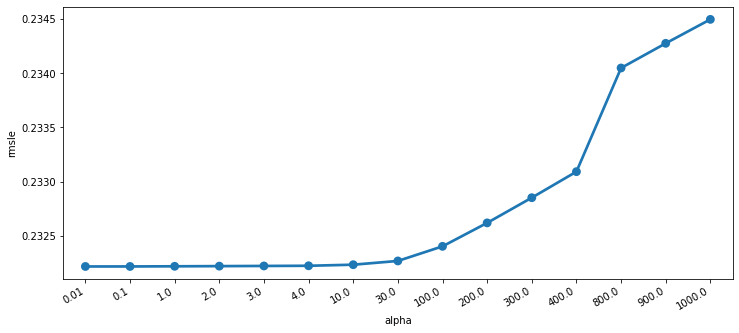

In [20]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### 라쏘 Regularization Model - Lasso
* 선형회귀의 Regularization(규제)를 적용하는 대안
* 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
* 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
* alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
* 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
* max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [21]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9796533426169105


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004802,0.002005,0.001860,0.000532,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-0.269724,-0.207771,-0.253418,-0.222550,-0.207610,-0.232215,0.025111,1
1,0.002917,0.000414,0.001175,0.000172,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-0.269726,-0.207772,-0.253418,-0.222550,-0.207609,-0.232215,0.025111,2
2,0.002131,0.000107,0.000861,0.000057,1,3000,"{'alpha': 1, 'max_iter': 3000}",-0.269737,-0.207776,-0.253416,-0.222546,-0.207605,-0.232216,0.025115,3
3,0.001714,0.000054,0.000715,0.000036,2,3000,"{'alpha': 2, 'max_iter': 3000}",-0.269750,-0.207781,-0.253415,-0.222542,-0.207601,-0.232218,0.025119,4
4,0.001522,0.000031,0.000671,0.000049,3,3000,"{'alpha': 3, 'max_iter': 3000}",-0.269763,-0.207787,-0.253413,-0.222538,-0.207597,-0.232220,0.025122,5


In [22]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.232215
1,0.10,0.232215
2,1.00,0.232216
3,2.00,0.232218
4,3.00,0.232220


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

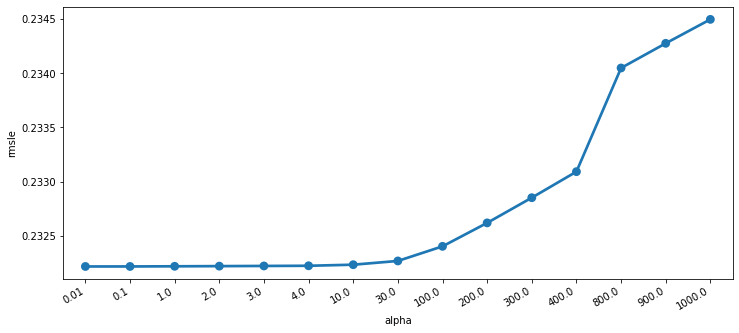

In [23]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## RandomForest

In [26]:
from sklearn.ensemble import RandomForestRegressor

rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
print("RMSLE Value For Random Forest : ", rmsle(np.exp(y_train_log), np.exp(preds), False))

RMSLE Value For Random Forest :  0.10567623656782144


### 앙상블 모델 - 그라디언트 부스트

### Ensemble Model - Gradient Boost
* 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
* 회귀와 분류에 모두 사용할 수 있음
* 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
* 무작위성이 없고 강력한 사전 가지치기가 사용 됨
* 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
* learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
* n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
* max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.20417262895601526


<AxesSubplot:ylabel='Density'>

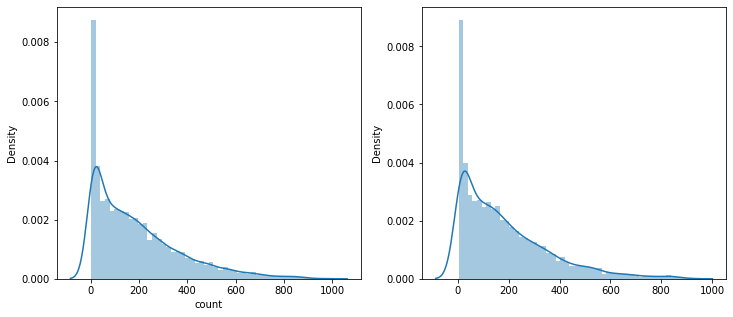

In [29]:
#예측
predsTest = rfModel.predict(X_test)

fig,(ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1, bins=50)
sns.distplot(np.exp(predsTest),ax=ax2, bins=50)

In [31]:
## Submit

submission = pd.read_csv("data/sampleSubmission.csv")
submission

submission['count'] = np.exp(predsTest)

print(submission.shape)
submission.head()

submission.to_csv("data/Score_{0:.5f}_submission.csv".format(score), index=False)

(6493, 2)


In [32]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,13.210147
1,2011-01-20 01:00:00,5.655529
2,2011-01-20 02:00:00,3.682364
3,2011-01-20 03:00:00,4.356074
4,2011-01-20 04:00:00,3.673981


In [33]:
score

0.20417262895601526